<img src='https://github.com/LinkedEarth/Logos/blob/master/Pyleoclim/PYLEOCLIM_logo_HORZ-01.png?raw=true' width="800">

# Filtering and Detrending with Pyleoclim

[Alexander James](https://orcid.org/0000-0001-8561-3188) & [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751) 

## Preamble

### Goals:

* Become familiar with the various filtering methods and some of their arguments
* Become familiar with the various detrending methods and some of their arguments

**Reading Time:**

10 minutes

### Keywords

Signal Processing; Visualization

### Pre-requisites

None. This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out this tutorial: [http://linked.earth/LeapFROGS/](http://linked.earth/LeapFROGS/).

### Relevant Packages

Pandas; Matplotlib

## Data Description

Benthic foraminifera $\delta^{18}O$ data from the [LR04 benthic stack](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071) ship (for free!) with `pyleoclim`

## Demonstration

Let's import pyleoclim, load and plot the data:

In [1]:
%load_ext watermark

import pyleoclim as pyleo

/Users/julieneg/Documents/GitHub/Pyleoclim_util/pyleoclim/core/surrogateseries.py:184: SyntaxWarning: invalid escape sequence '\p'
  '''


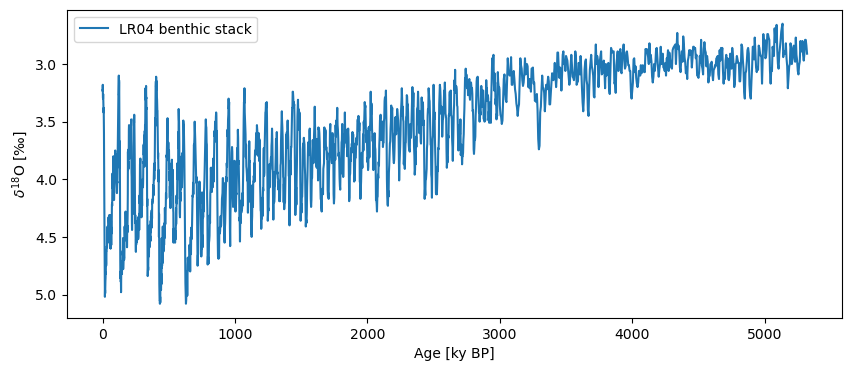

In [2]:
lr04 = pyleo.utils.load_dataset('LR04')
fig, ax = lr04.plot(invert_yaxis=True)

### Detrending

To detrend the data using `pyleoclim` we simply call the `.detrend()` method on a `Series` object. There are several detrending methods which are covered more thoroughly by the [documentation](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.detrend).

In this case, we'll use the EMD (Empirical Mode Decomposition) method. This decomposes the series into different modes and removes the last one on the assumption that it describes the trend in the series.

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>

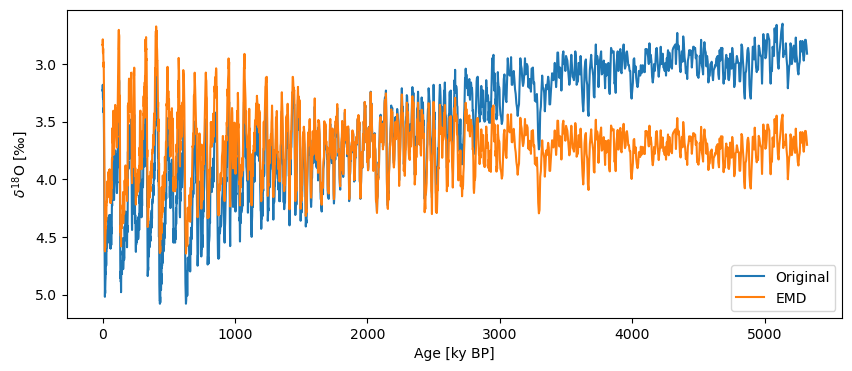

In [3]:
ts_emd = lr04.detrend(method='emd', preserve_mean=True, keep_log=True)
fig, ax = lr04.plot(label='Original', invert_yaxis=True)
ts_emd.plot(label='EMD',ax=ax)

You can also pass method-dependent keyword arguments for each of the different methods. For example, with EMD, if we specify a value for the keyword `n`, it will remove the n smoothest modes rather than the single smoothest mode (by default, `n=1`).

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>

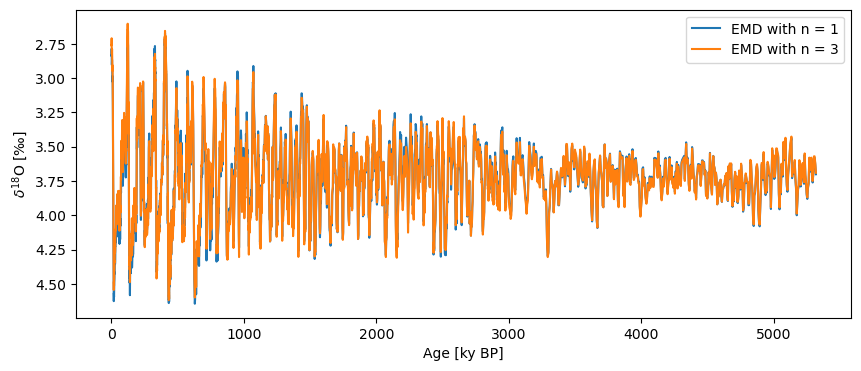

In [4]:
ts_emd_n = lr04.detrend(n=3, preserve_mean=True)
fig, ax = ts_emd.plot(label='EMD with n = 1', invert_yaxis=True)
ts_emd_n.plot(label='EMD with n = 3',ax=ax)

As you can see, this isn't really necessary for this record, but it does come in handy on occasion, and other methods can be more sensitive to parameter values, so it's good to be aware that some configurability exists. Note that these keyword arguments are **method dependent**, meaning that you'll need to consult the [documentation](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#pyleoclim.core.series.Series.detrend) for each in order to make sure you know which keyword arguments can be used with each method.

Note that we passed two optional arguments: one to preserve the mean of the original series (`preserve_mean = True`), so it would plot nicely along the original; the other is to keep the [log](./L2_tracing_transformations.md), so we can easily extract the trend. To plot it, you can do this:  

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>)

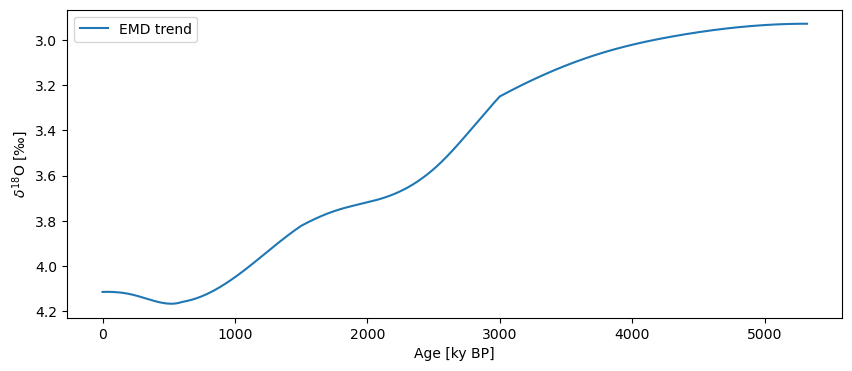

In [5]:
trend_emd = ts_emd.copy()
trend_emd.value = ts_emd.log[0]['previous_trend']
trend_emd.label = 'EMD trend'
trend_emd.plot(invert_yaxis=True)

There are other methods available to us such as `linear`, `savitzky-golay`, and `constant`.  The latter option is not terribly useful, as it just removes a constant from the series. Linear detrending is generally a sensible path, but it is obvious here that the trend is nonlinear. `savitzky-golay` is quite good at extracting those:

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>

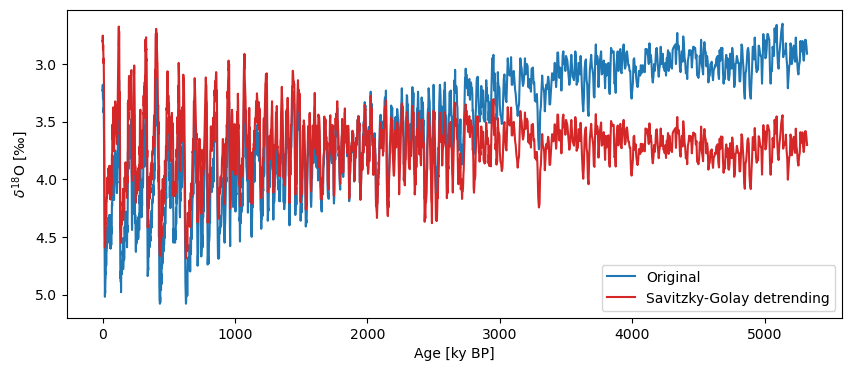

In [6]:
ts_sg = lr04.detrend(method='savitzky-golay', preserve_mean=True, keep_log=True)
fig, ax = lr04.plot(label='Original', invert_yaxis=True)
ts_sg.plot(label='Savitzky-Golay detrending',ax=ax, color = 'C3')

Note that the method also assumes evenly-spaced data, and having found unevenly-spaced data, it applied interpolation under the hood to get what it needed. If the regridding choice matters, it would be better to do this outside of `detrend()`. 
In any case, the result is rather similar to EMD, so let's isolate the trend for a more quantitative comparison:

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>

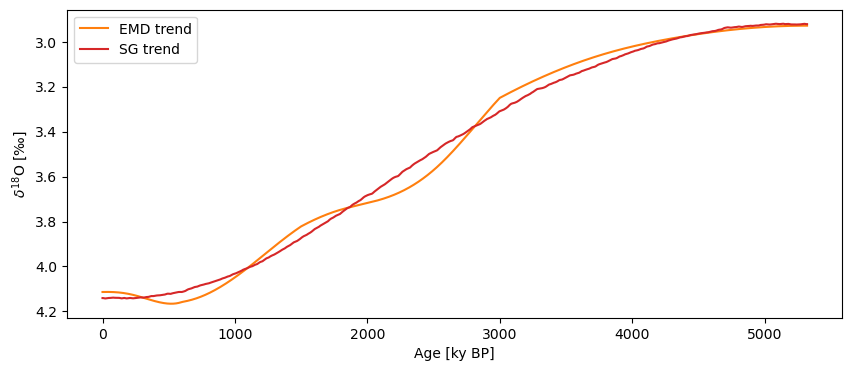

In [7]:
trend_sg = ts_sg.copy()
trend_sg.value = ts_sg.log[0]['previous_trend']
trend_sg.label = 'SG trend'
fig, ax = trend_emd.plot(invert_yaxis=True, color = 'C1')
trend_sg.plot(ax=ax, color = 'C3')

Savitzky-Golay is indeed very good at isolating the lowest-frequency component. Note that the millennial-scale wiggles present with EMD would show up in a spectrum, so be exceeding careful when applying detrending prior to spectral analysis, as it could create artifacts. 

### Filtering

Technically, Savitzky-Golay is a filter, and can be used as such. `Pyleoclim` incorporates a [vast array of filters](https://pyleoclim-util.readthedocs.io/en/master/core/api.html?highlight=lipd#pyleoclim.core.series.Series.filter), some inherited from the SciPy library.  To filter a `Series` object, simply apply the `.filter()` method. One innovation of our package is that is makes it easy to specify either a cutoff scale (period) or a cutoff frequency.  

Let's use the lanczos filter with a `cutoff_scale` of 80 to remove all frequencies with a period of less than 80ka (we pass the number 80 because our time axis is already in units of ka). This is known as a low-pass filter. We have to interpolate the series because the Lanczos method expects an evenly-spaced series. See the [uniform time sampling](L1_uniform_time_sampling.md) tutorial for more information on interpolation and other methods of creating evenly-spaced time series.

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>

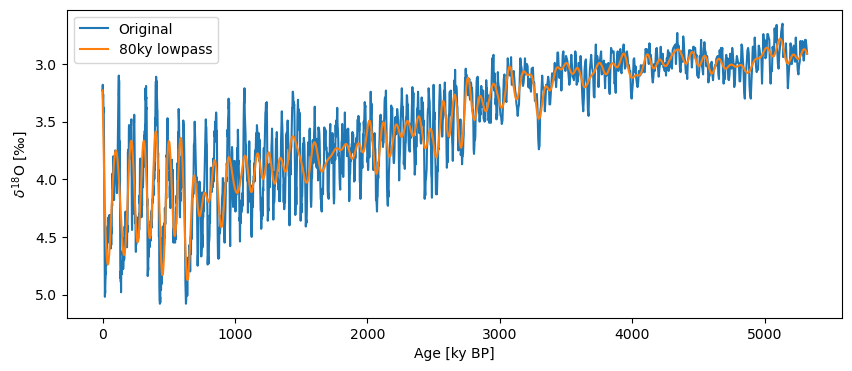

In [8]:
ts_low = lr04.interp().filter(method='lanczos',cutoff_scale=80)
fig, ax = lr04.plot(label='Original')
ts_low.plot(label='80ky lowpass',ax=ax, invert_yaxis=True)

One could also pass a cutoff frequency (`cutoff_freq=...`) , though we find the cutoff scale more user-friendly.

If we look at the results of performing wavelet analysis on our series before and after filtering, we can clearly see the effect of our low pass filter. You can learn more about spectral analysis in Pyleoclim in the [spectral analysis tutorial]().

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


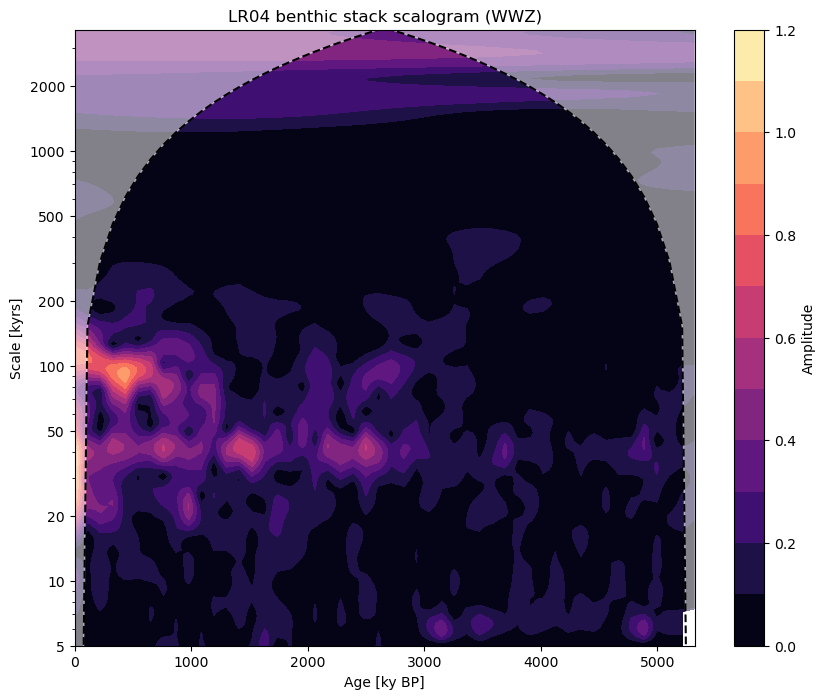

In [9]:
fig, ax = lr04.wavelet(method='wwz').plot()

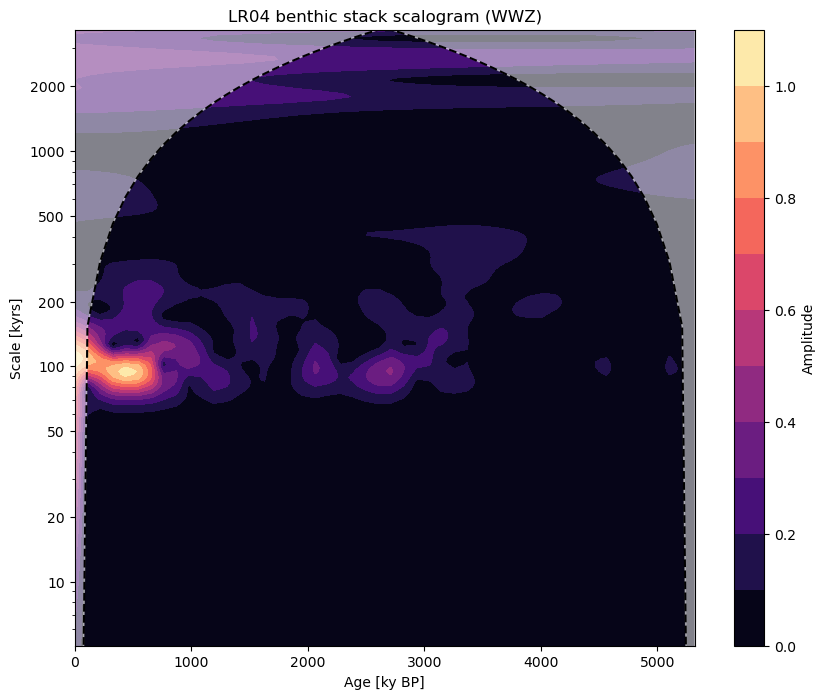

In [10]:
fig, ax = ts_low.wavelet(method='wwz').plot()

If we want to apply a band pass filter, we can pass a list of values to our `cutoff_scale` argument.

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>

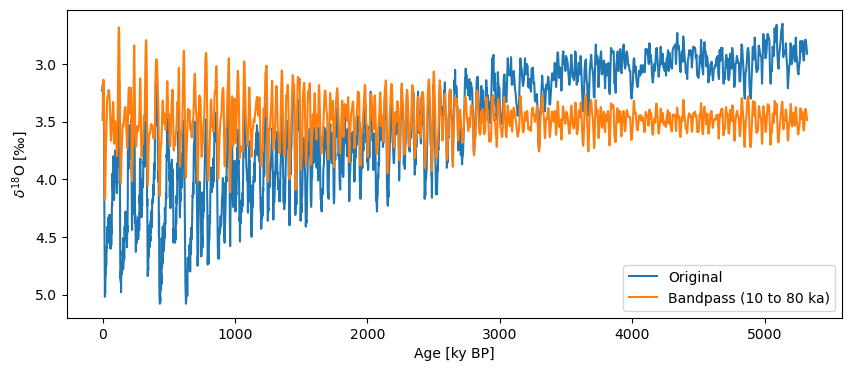

In [11]:
ts_band = lr04.interp().filter(method='butterworth',cutoff_scale=[10,80])
fig, ax = lr04.plot(label='Original')
ts_band.plot(label='Bandpass (10 to 80 ka)',ax=ax, invert_yaxis=True)

Checking our work by running wavelet analysis (done below) shows that we've isolated the components of the series whose periodicities lie between 10 and 80ka.

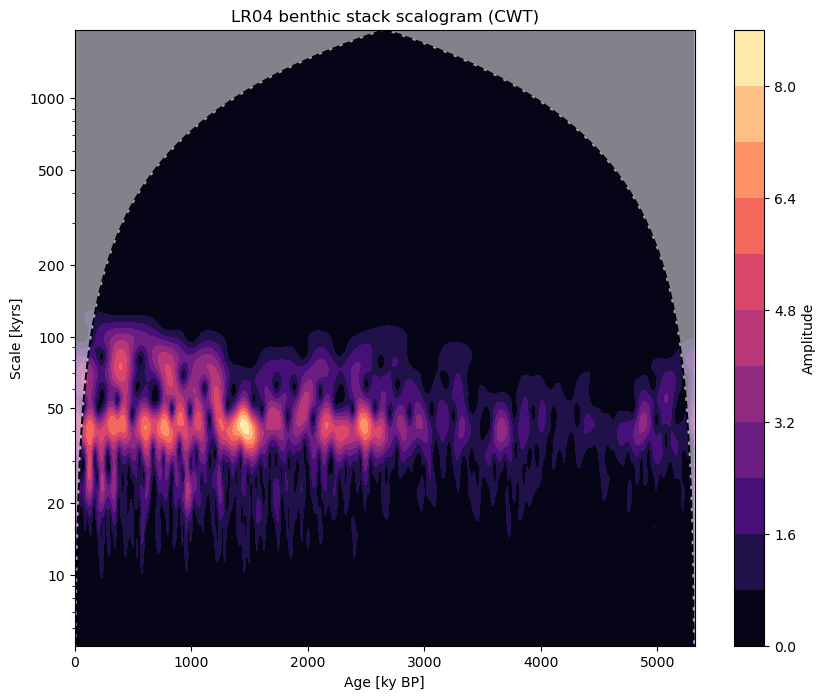

In [12]:
fig, ax = ts_band.wavelet(method='cwt').plot()

To apply a high pass filter, we simply apply a lowpass filter and then subtract the values of the low pass filter series from our original series.

In [13]:
#Applying a high pass filter with a cutoff_scale of 50

ts_high = lr04.copy()
ts_high.value -= lr04.interp().filter(method='lanczos',cutoff_scale=50).value

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>

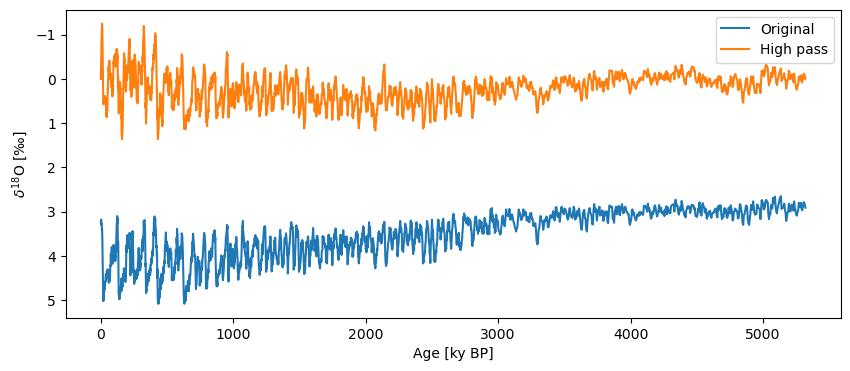

In [14]:
fig, ax = lr04.plot(label='Original',invert_yaxis=True)
ts_high.plot(label='High pass',ax=ax)

Though removal of the long term trend in our series is an obvious consequence of our high pass filter, wavelet analysis should show us how the frequency profile of this series has changed.

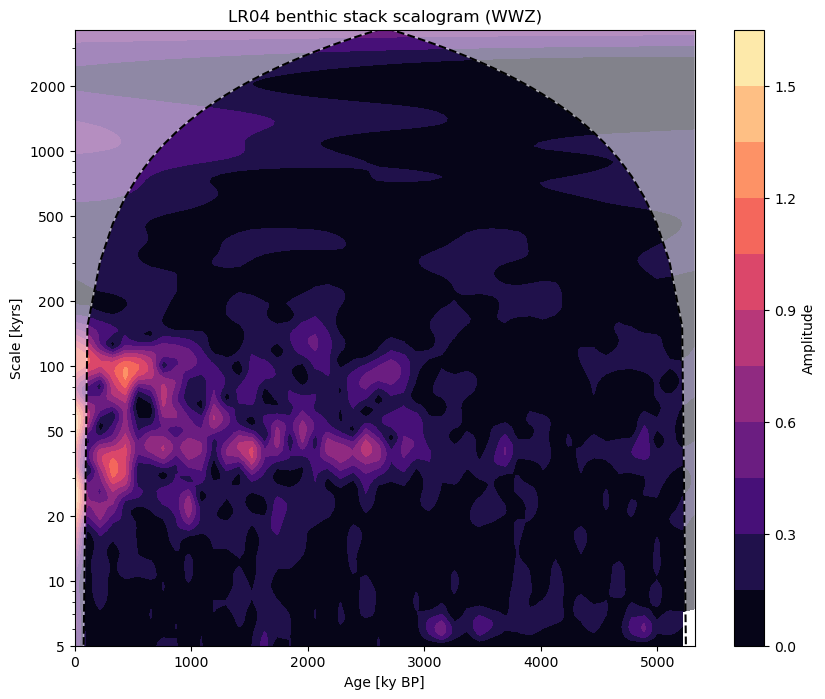

In [15]:
fig, ax = ts_high.wavelet(method='wwz').plot()

It's not perfect, but the power of the components of the series with longer periodicities has decreased.

As with `.detrend()`, `.filter()` accepts method-specific keyword arguments. For example, in the case of the savitzky-golay method, we can pass `window_length` to adjust the size of the filter window. 

In [16]:
ts_sg_low = lr04.interp().filter(method='savitzky-golay',cutoff_scale=80)
ts_sg_win = lr04.interp().filter(method='savitzky-golay',cutoff_scale=80,window_length=81)

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>

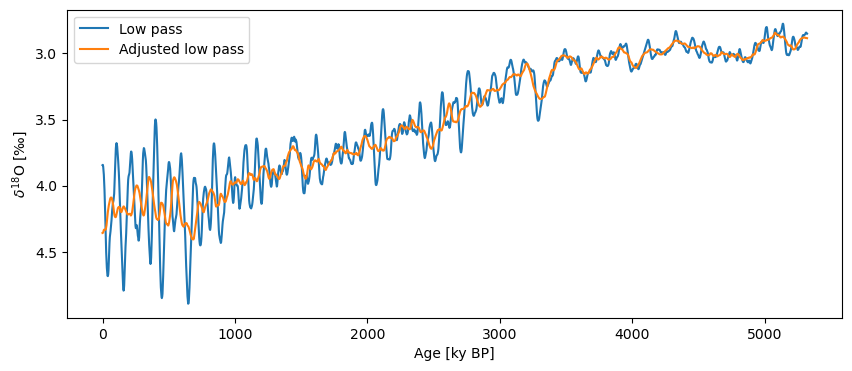

In [17]:
fig, ax = ts_sg_low.plot(label='Low pass')
ts_sg_win.plot(label='Adjusted low pass',ax=ax, invert_yaxis=True)

There are a number of other methods we could use here including: `butterworth`, `lanczos`, and `firwin`. Each has its own keyword arguments. Exploring these (and their [documentation](https://pyleoclim-util.readthedocs.io/en/master/core/api.html?highlight=lipd#pyleoclim.core.series.Series.filter)), is left as an exercise for the reader.

Finally, note that singular spectrum analysis is another option to isolate particular components of a signal. As the [dedicated tutorial](L2_singular_spectrum_analysis.ipynb) shows, it can function for detrending or filtering as well. 

In [18]:
%watermark -n -u -v -iv -w

Last updated: Thu Jul 10 2025

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 9.3.0

IPython  : 9.3.0
pyleoclim: 1.2.1
sys      : 3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:36:57) [Clang 15.0.7 ]
json     : 2.0.9

Watermark: 2.5.0

